<a href="https://colab.research.google.com/github/salexey1990/gb/blob/master/ml-business/hw05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor

import statsmodels.api as sm
from random import random

from google.colab import files
import io

import itertools
import warnings

In [5]:
uploaded_brent = files.upload()
uploaded_eur = files.upload()
uploaded_usd = files.upload()

Saving my_BRENT2019.csv to my_BRENT2019 (1).csv


Saving R_E01_09_2010_T01_09_2019.xlsx to R_E01_09_2010_T01_09_2019.xlsx


Saving RC_F01_09_2010_T01_09_2019.xlsx to RC_F01_09_2010_T01_09_2019.xlsx


In [125]:
df_brent = pd.read_csv(io.BytesIO(uploaded['my_BRENT2019.csv']), index_col=[0], parse_dates=[0])
d_df_brent = df_brent['Значение'].values[1:]- df_brent['Значение'].values[:-1]
df_brent = df_brent[:-1]
df_brent['Значение'] = d_df_brent

df_usd = pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx')
df_usd.index = pd.to_datetime(df_usd['data'].values).date
df_usd.drop(['nominal','cdx','data'], axis=1,inplace = True)
d_df_usd = df_usd['curs'].values[1:]- df_usd['curs'].values[:-1]
df_usd = df_usd[:-1]
df_usd['curs'] = d_df_usd

df_eur=pd.read_excel('R_E01_09_2010_T01_09_2019.xlsx')
df_eur.index = pd.to_datetime(df_eur['data'].values).date
df_eur.drop(['nominal','cdx','data'], axis=1,inplace = True)
d_df_eur = df_eur['curs'].values[1:]- df_eur['curs'].values[:-1]
df_eur = df_eur[:-1]
df_eur['curs'] = d_df_eur

df = pd.merge(df_brent, df_eur, left_index=True, right_index=True)
df = pd.merge(df, df_usd, left_index=True, right_index=True)
df_w = df.resample('W').mean()
df_w.index.name = 'Date'
df_w = df_w.dropna()
df_w.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,curs_x,curs_y
Date,,,,,,,,,,,,,
2010-09-05,0.0650,2010.0,9.00,2.5,3.00,245.5,35.0,3.5,0.0,0.0,0.0,0.114825,-0.072450
2010-09-12,0.3860,2010.0,9.00,9.0,3.00,252.0,36.0,3.0,0.0,0.0,0.2,-0.029700,0.021200
2010-09-19,-0.2175,2010.0,9.00,15.5,3.00,258.5,37.0,2.5,0.0,0.0,0.0,0.372000,0.099875
2010-09-26,0.2100,2010.0,9.00,22.5,3.00,265.5,38.0,2.5,0.0,0.0,0.0,0.179575,-0.008225
2010-10-03,1.2100,2010.0,9.25,22.0,3.25,272.5,39.0,2.5,0.0,0.0,0.0,0.109650,-0.025625


In [0]:
# функция экспоненциального сглаживания датасета
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [0]:
# функция для подсчёта ошибки модели
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:

# функция разбиения датасета на тестовую и валидационную выборки 
def split_data_b( data, split_date ):
  data = data[['Значение', 't', 't1', 't2', 'curs_x', 'curs_y']]
  return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
          data.loc[data.index.get_level_values('Date') >  split_date].copy()

In [129]:
df_w['t'] = 0
df_w.iloc[1:,13]=df_w.iloc[:-1,0].values
df_w['t1']=0
df_w.iloc[2:,14]=df_w.iloc[:-2,0].values
df_w['t2']=0
df_w.iloc[3:,15]=df_w.iloc[:-3,0].values
df_w.fillna(0)

df_w.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,curs_x,curs_y,t,t1,t2
Date,,,,,,,,,,,,,,,,
2010-09-05,0.0650,2010.0,9.00,2.5,3.00,245.5,35.0,3.5,0.0,0.0,0.0,0.114825,-0.072450,0.0000,0.0000,0.000
2010-09-12,0.3860,2010.0,9.00,9.0,3.00,252.0,36.0,3.0,0.0,0.0,0.2,-0.029700,0.021200,0.0650,0.0000,0.000
2010-09-19,-0.2175,2010.0,9.00,15.5,3.00,258.5,37.0,2.5,0.0,0.0,0.0,0.372000,0.099875,0.3860,0.0650,0.000
2010-09-26,0.2100,2010.0,9.00,22.5,3.00,265.5,38.0,2.5,0.0,0.0,0.0,0.179575,-0.008225,-0.2175,0.3860,0.065
2010-10-03,1.2100,2010.0,9.25,22.0,3.25,272.5,39.0,2.5,0.0,0.0,0.0,0.109650,-0.025625,0.2100,-0.2175,0.386


In [130]:
df_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 461 entries, 2010-09-05 to 2019-09-01
Data columns (total 16 columns):
Значение           461 non-null float64
year               461 non-null float64
month              461 non-null float64
dayofmonth         461 non-null float64
quarter            461 non-null float64
dayofyear          461 non-null float64
weekofyear         461 non-null float64
dayofweek          461 non-null float64
is_holiday         461 non-null float64
is_prev_holiday    461 non-null float64
is_next_holiday    461 non-null float64
curs_x             461 non-null float64
curs_y             461 non-null float64
t                  461 non-null float64
t1                 461 non-null float64
t2                 461 non-null float64
dtypes: float64(16)
memory usage: 61.2 KB


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


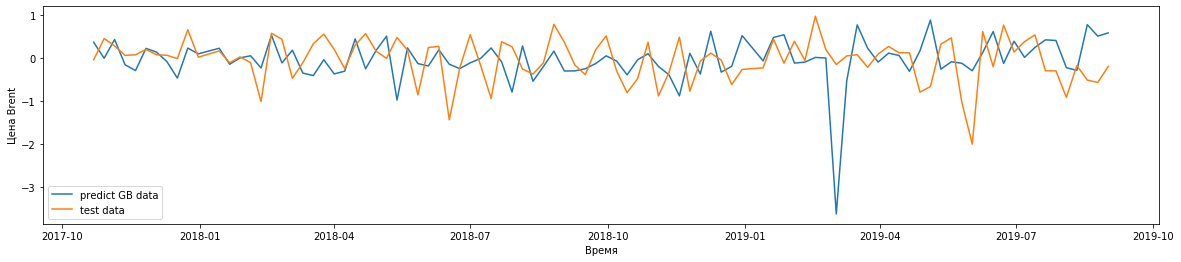

ошибка градиентного бустинга :   inf %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [131]:

model_gb_h1 = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
train_b, test_b = split_data_b( df_w, '10-10-2017')

h=1
X_train_b_h1 = train_b.iloc[:-h,:]
y_train_b_h1 = train_b[df_w.columns[0]].values[h:]
X_test_b_h1 = test_b.iloc[:-h,:]
y_test_b_h1 = test_b[df_w.columns[0]].values[h:]

model_gb_h1.fit( X_train_b_h1, y_train_b_h1 ) 
y_test_pred_gb_h1 = model_gb_h1.predict(X_test_b_h1)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Цена Brent')
plt.plot(test_b.index[h:],y_test_pred_gb_h1, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b_h1, label='test data')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b_h1, y_pred=y_test_pred_gb_h1)

print('ошибка градиентного бустинга :  ', er_g, '%')